# IMPORTS

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# STRATEGY PREPARATION

In [255]:
def performance(x, ntrades=1, cost=0):
    # We define everything we need to test the performance of the strategy with the metrics we have seen in class
    
    x = x[1:]
    cumRetx = np.cumsum(x, axis=0) - ntrades * cost
    annRetx = (np.power(cumRetx.iloc[-1] + 1, 252 / len(x)) - 1)
    sharpex = annRetx / np.std(x, ddof=1) * np.sqrt(252)
    winpctx = np.count_nonzero(x > 0) / np.count_nonzero(x)
    annSDx = np.std(x, ddof=1) * np.sqrt(252)

    DDs = np.minimum.accumulate(cumRetx) - cumRetx
    maxDDx = DDs.min()
    maxLx = (cumRetx == DDs).argmax()

    Perf = np.array([cumRetx.iloc[-1], annRetx, sharpex, winpctx, annSDx, maxDDx, maxLx, ntrades])
    names = np.array(["Cumulative Return", "Annual Return", "Annualized Sharpe Ratio",
                        "Win %", "Annualized Volatility", "Maximum Drawdown", "Max Length Drawdown", "n.trades"])
    return pd.Series(Perf, index=names, name=x.name)

In [256]:
def test_sentiment_strategy(myStock, ev, threshold=50, long_only=True, tcost=0):
    """
    Test a trading strategy based on sentiment indicators.
    """
    # Define the trading strategy
    condition = (ev['BBr'] > threshold)# & (ev['RVT'] > threshold_RVT)
    if long_only:
        sig = pd.Series(np.where(condition, 1, 0), index=ev.index).shift(1)
    else:
        sig = pd.Series(np.where(condition, 1, -1), index=ev.index).shift(1)
    sig.index = myStock.index

    bmkReturns = (myStock / myStock.shift(1) - 1).dropna()
    myReturns = bmkReturns * sig.reindex(bmkReturns.index).fillna(0)
    myReturns.name = "Sentiment"
    bmkReturns.name = "BH"

    # Join the returns of the strategy and the benchmark
    tt = pd.concat([myReturns, bmkReturns], axis=1).dropna()

    lruns = np.count_nonzero(np.diff(sig.dropna())) + 1
    bhPerf = performance(tt['BH'], 2, tcost)
    sentimentPerf = performance(tt['Sentiment'], lruns, tcost)

    # plot the performance of the strategy and the benchmark
    plt.figure(figsize=(12, 6))
    plt.plot(np.cumsum(tt['Sentiment'], axis=0), label="Sentiment")
    plt.plot(np.cumsum(tt['BH'], axis=0), label="BH")

    # we auto-adjust the x-axis labels
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Cumulative Values')
    plt.title('Cumulative Sentiment and BH Over Time')
    plt.gcf().autofmt_xdate()
    plt.show()
    
    return pd.concat([sentimentPerf, bhPerf], axis=1)

In [257]:
def rolling_test_sentiment_strategy(my_stock, ev, threshold=50, long_only=True, w_size=252):
    # We use the same strategy as before
    condition = (ev['BBr'] > threshold)# & (ev['RVT'] > threshold_RVT)
    if long_only:
        sig = pd.Series(np.where(condition, 1, 0), index=ev.index).shift(1)
    else:
        sig = pd.Series(np.where(condition, 1, -1), index=ev.index).shift(1)
    
    sig.index = ev.index
    
    bmk_returns = (my_stock / my_stock.shift(1) - 1).rename("BH")
    my_returns = bmk_returns * sig.reindex(bmk_returns.index).fillna(0)
    my_returns.rename("Me", inplace=True)
    tt = pd.concat([bmk_returns, my_returns], axis=1).dropna()
    n_windows = int(tt.shape[0] - w_size)
    if n_windows < 1:
        raise ValueError("Window size too large")
    
    # We calculate the performance of the strategy and the benchmark
    perform = []
    for i in range(n_windows):
        bh_stra = tt.iloc[i:w_size+i, 0]
        my_stra = tt.iloc[i:w_size+i, 1]
        perform.append([bh_stra.mean(), my_stra.mean()])
    perform = np.array(perform)
    
    # We calculate the average performance of the strategy and the benchmark
    bh_means = perform[:,0].mean()
    me_means = perform[:,1].mean()
    mean_perf = np.array([bh_means, me_means])
    mean_perf = pd.DataFrame(mean_perf, index=["BH", "Me"], columns=["AvgPerf"])
    
    return {"AvgPerf": mean_perf, "NumWindows": n_windows}

# DATA PREPARATION

In [258]:
# We load the datasets from AAPL and FB stocks
aapl = pd.read_csv('data/AAPL.csv')
fb = pd.read_csv('data/FB.csv')

# We drop the index we had from the .csv document
aapl.drop('Unnamed: 0', axis=1, inplace=True)
fb.drop('Unnamed: 0', axis=1, inplace=True)

# We convert the date column to datetime
aapl['Date'] = pd.to_datetime(aapl['Date'])
fb['Date'] = pd.to_datetime(fb['Date'])

# We duplicate the date column to use it as the index of the dataset but also for the plots.
aapl['Date2'] = aapl['Date']
fb['Date2'] = fb['Date']

# We set the date as the index of the dataset
aapl.set_index('Date2', inplace=True)
fb.set_index('Date2', inplace=True)

In [259]:
def calculate_indicators(df):
    df['BULL'] = df['positivePartscr'] + df['certaintyPartscr'] + df['finupPartscr']
    df['BEAR'] = df['negativePartscr'] + df['uncertaintyPartscr'] + df['findownPartscr']
    df['BBr'] = 100 * df['BULL'] / (df['BULL'] + df['BEAR'])
    df['PNlog'] = 0.5 * np.log((df['positivePartscr'] + 1) / (df['negativePartscr'] + 1))
    return df

aapl = calculate_indicators(aapl)
fb = calculate_indicators(fb)

In [260]:
aapl_target = aapl['Adj Close']
fb_target = fb['Adj Close']

aapl_ev = aapl[['BBr', 'RVT']]
fb_ev = fb[['BBr', 'RVT']]

# LONG ONLY AND WINDOW SIZE OF 1 YEAR

/var/folders/jp/ccdbvftd4pg2qt6s4b7bkv5m0000gn/T/ipykernel_11120/1773503202.py:6: RuntimeWarning: invalid value encountered in power
  annRetx = (np.power(cumRetx.iloc[-1] + 1, 252 / len(x)) - 1)


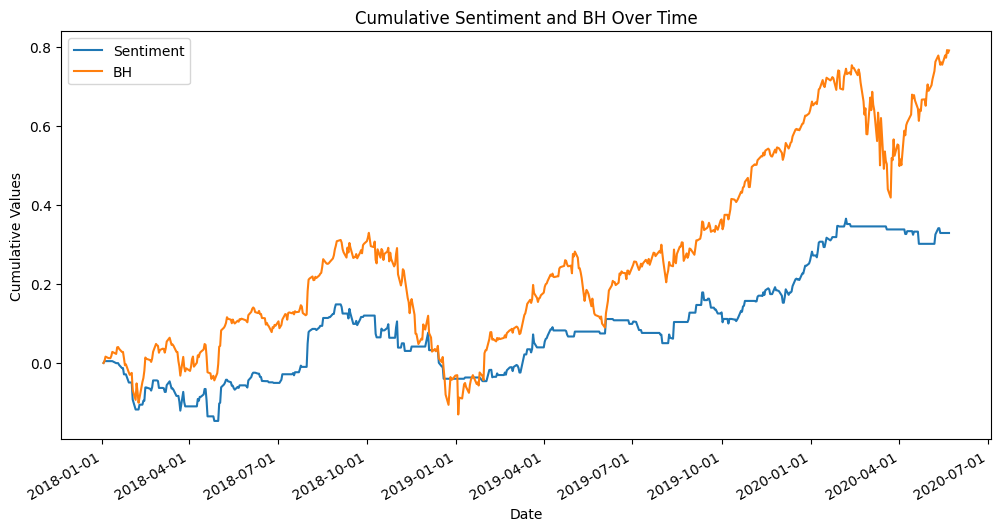

/var/folders/jp/ccdbvftd4pg2qt6s4b7bkv5m0000gn/T/ipykernel_11120/1773503202.py:6: RuntimeWarning: invalid value encountered in power
  annRetx = (np.power(cumRetx.iloc[-1] + 1, 252 / len(x)) - 1)


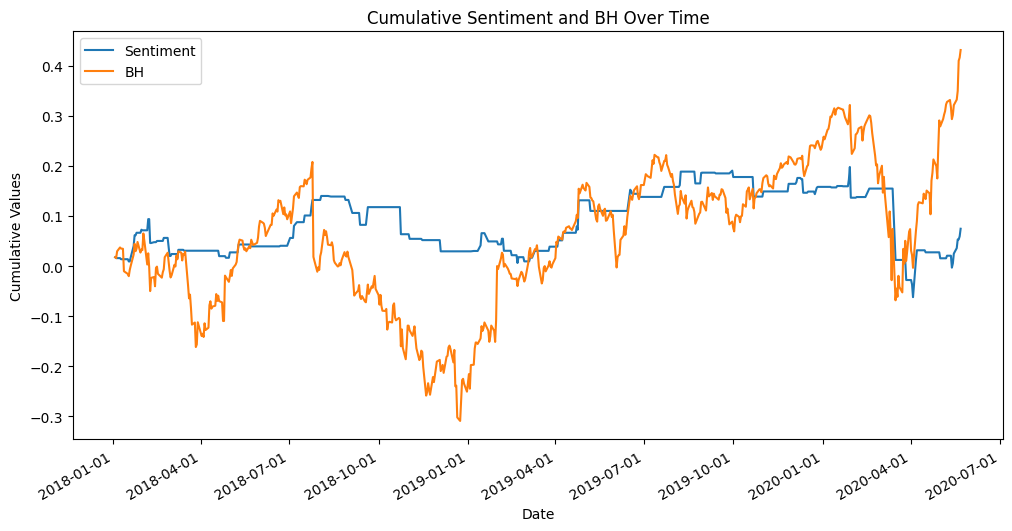

AAPL Results:
                           Sentiment          BH
Cumulative Return         -1.850792    0.771744
Annual Return                   NaN    0.271535
Annualized Sharpe Ratio         NaN  199.379302
Win %                      0.521739    0.541667
Annualized Volatility      0.165813    0.343199
Maximum Drawdown          -0.512420   -0.923330
Max Length Drawdown        0.000000    0.000000
n.trades                 218.000000    2.000000


FB Results:
                           Sentiment         BH
Cumulative Return         -1.573153   0.393796
Annual Return                   NaN   0.149645
Annualized Sharpe Ratio         NaN  99.713469
Win %                      0.557522   0.525084
Annualized Volatility      0.161414   0.378188
Maximum Drawdown          -0.191718  -0.740794
Max Length Drawdown        0.000000   0.000000
n.trades                 163.000000   2.000000


In [261]:
# Full period test
aapl_res = test_sentiment_strategy(aapl_target, aapl_ev, threshold=50, long_only=True, tcost=0.01)
fb_res = test_sentiment_strategy(fb_target, fb_ev, threshold=50, long_only=True, tcost=0.01)

print("AAPL Results:\n", aapl_res)
print('\n')
print("FB Results:\n", fb_res)

In [262]:
# Rolling window analysis
aapl_rolling_perf = rolling_test_sentiment_strategy(aapl_target, aapl_ev, threshold=50, long_only=True, w_size=254)
fb_rolling_perf = rolling_test_sentiment_strategy(fb_target, fb_ev, threshold=50, long_only=True, w_size=254)

print("AAPL Rolling Performance:\n", aapl_rolling_perf)
print('\n')
print("FB Rolling Performance:\n", fb_rolling_perf)

AAPL Rolling Performance:
 {'AvgPerf':      AvgPerf
BH  0.001050
Me  0.000605, 'NumWindows': 347}


FB Rolling Performance:
 {'AvgPerf':      AvgPerf
BH  0.000583
Me  0.000191, 'NumWindows': 347}


# LONG SHORT AND WINDOW SIZE OF 1 YEAR

/var/folders/jp/ccdbvftd4pg2qt6s4b7bkv5m0000gn/T/ipykernel_11120/1773503202.py:6: RuntimeWarning: invalid value encountered in power
  annRetx = (np.power(cumRetx.iloc[-1] + 1, 252 / len(x)) - 1)


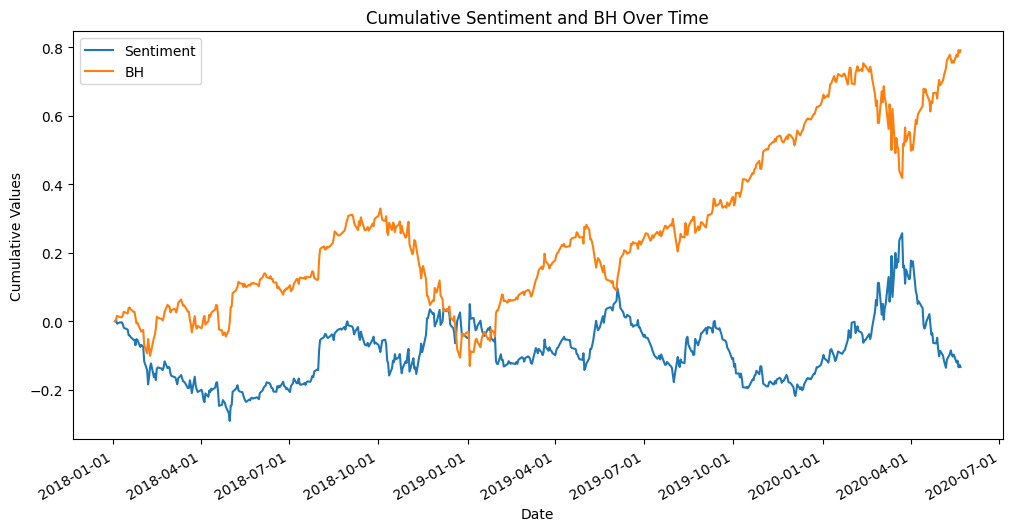

/var/folders/jp/ccdbvftd4pg2qt6s4b7bkv5m0000gn/T/ipykernel_11120/1773503202.py:6: RuntimeWarning: invalid value encountered in power
  annRetx = (np.power(cumRetx.iloc[-1] + 1, 252 / len(x)) - 1)


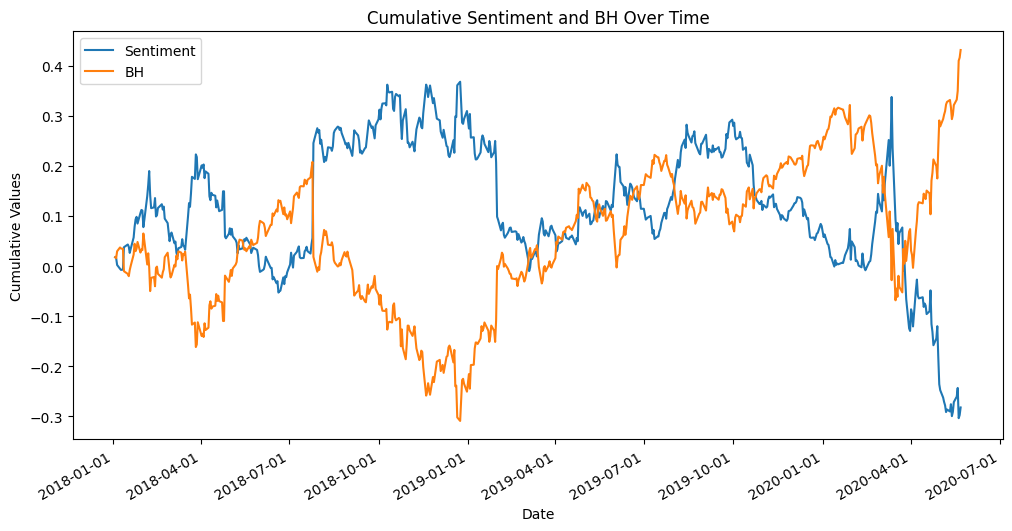

AAPL Results:
                           Sentiment          BH
Cumulative Return         -2.313328    0.771744
Annual Return                   NaN    0.271535
Annualized Sharpe Ratio         NaN  199.379302
Win %                      0.476667    0.541667
Annualized Volatility      0.343821    0.343199
Maximum Drawdown          -0.548507   -0.923330
Max Length Drawdown        0.000000    0.000000
n.trades                 218.000000    2.000000


FB Results:
                           Sentiment         BH
Cumulative Return         -1.930102   0.393796
Annual Return                   NaN   0.149645
Annualized Sharpe Ratio         NaN  99.713469
Win %                      0.496656   0.525084
Annualized Volatility      0.378264   0.378188
Maximum Drawdown          -0.421088  -0.740794
Max Length Drawdown        0.000000   0.000000
n.trades                 163.000000   2.000000


In [263]:
# Full period test
aapl_res = test_sentiment_strategy(aapl_target, aapl_ev, threshold=50, long_only=False, tcost=0.01)
fb_res = test_sentiment_strategy(fb_target, fb_ev, threshold=50, long_only=False, tcost=0.01)

print("AAPL Results:\n", aapl_res)
print('\n')
print("FB Results:\n", fb_res)

In [264]:
# Rolling window analysis
aapl_rolling_perf = rolling_test_sentiment_strategy(aapl_target, aapl_ev, threshold=50, long_only=False, w_size=254)
fb_rolling_perf = rolling_test_sentiment_strategy(fb_target, fb_ev, threshold=50, long_only=False, w_size=254)

print("AAPL Rolling Performance:\n", aapl_rolling_perf)
print('\n')
print("FB Rolling Performance:\n", fb_rolling_perf)

AAPL Rolling Performance:
 {'AvgPerf':     AvgPerf
BH  0.00105
Me  0.00016, 'NumWindows': 347}


FB Rolling Performance:
 {'AvgPerf':      AvgPerf
BH  0.000583
Me -0.000201, 'NumWindows': 347}


# LONG ONLY AND WINDOW SIZE OF 6 MONTHS

/var/folders/jp/ccdbvftd4pg2qt6s4b7bkv5m0000gn/T/ipykernel_11120/1773503202.py:6: RuntimeWarning: invalid value encountered in power
  annRetx = (np.power(cumRetx.iloc[-1] + 1, 252 / len(x)) - 1)


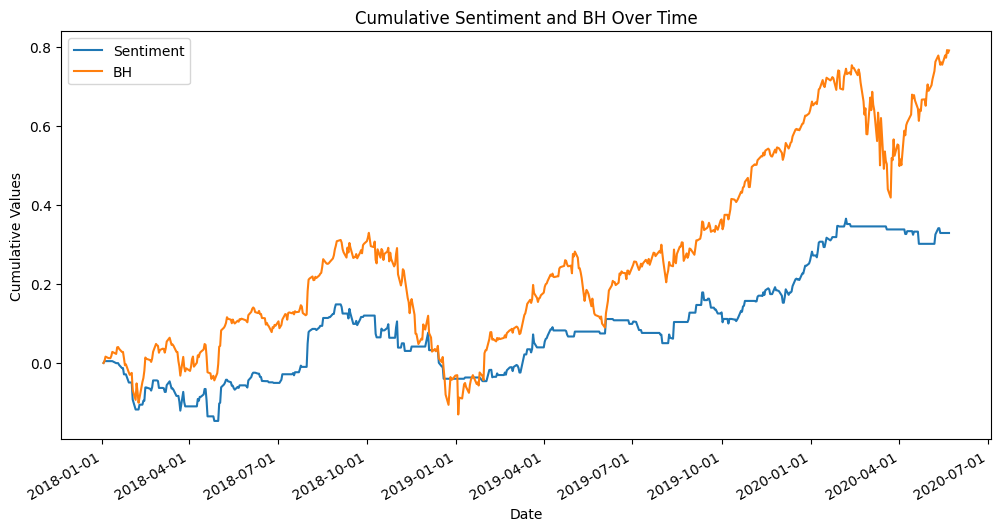

/var/folders/jp/ccdbvftd4pg2qt6s4b7bkv5m0000gn/T/ipykernel_11120/1773503202.py:6: RuntimeWarning: invalid value encountered in power
  annRetx = (np.power(cumRetx.iloc[-1] + 1, 252 / len(x)) - 1)


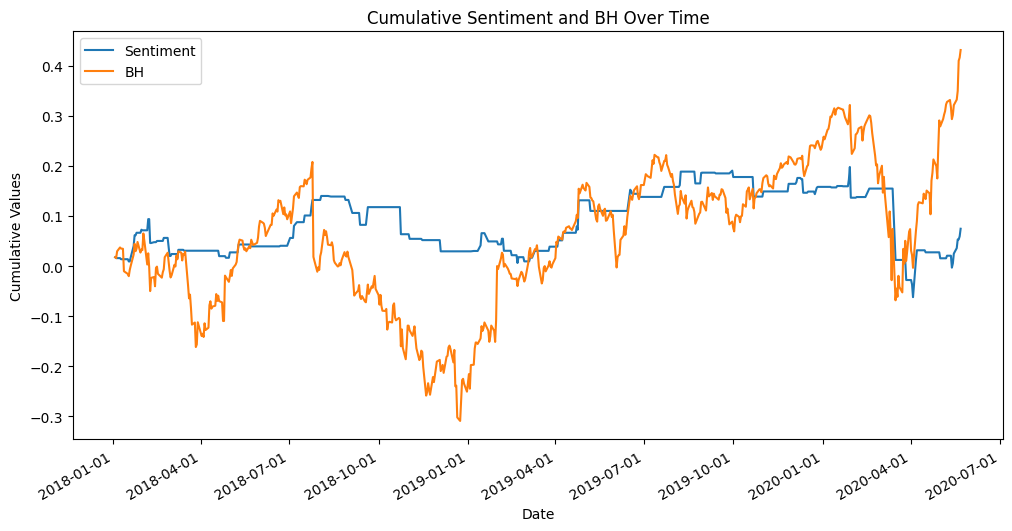

AAPL Results:
                           Sentiment          BH
Cumulative Return         -1.850792    0.771744
Annual Return                   NaN    0.271535
Annualized Sharpe Ratio         NaN  199.379302
Win %                      0.521739    0.541667
Annualized Volatility      0.165813    0.343199
Maximum Drawdown          -0.512420   -0.923330
Max Length Drawdown        0.000000    0.000000
n.trades                 218.000000    2.000000


FB Results:
                           Sentiment         BH
Cumulative Return         -1.573153   0.393796
Annual Return                   NaN   0.149645
Annualized Sharpe Ratio         NaN  99.713469
Win %                      0.557522   0.525084
Annualized Volatility      0.161414   0.378188
Maximum Drawdown          -0.191718  -0.740794
Max Length Drawdown        0.000000   0.000000
n.trades                 163.000000   2.000000


In [265]:
# Full period test
aapl_res = test_sentiment_strategy(aapl_target, aapl_ev, threshold=50, long_only=True, tcost=0.01)
fb_res = test_sentiment_strategy(fb_target, fb_ev, threshold=50, long_only=True, tcost=0.01)

print("AAPL Results:\n", aapl_res)
print('\n')
print("FB Results:\n", fb_res)

In [266]:
# Rolling window analysis
aapl_rolling_perf = rolling_test_sentiment_strategy(aapl_target, aapl_ev, threshold=50, long_only=True, w_size=127)
fb_rolling_perf = rolling_test_sentiment_strategy(fb_target, fb_ev, threshold=50, long_only=True, w_size=127)

print("AAPL Rolling Performance:\n", aapl_rolling_perf)
print('\n')
print("FB Rolling Performance:\n", fb_rolling_perf)

AAPL Rolling Performance:
 {'AvgPerf':      AvgPerf
BH  0.001268
Me  0.000763, 'NumWindows': 474}


FB Rolling Performance:
 {'AvgPerf':      AvgPerf
BH  0.000419
Me  0.000138, 'NumWindows': 474}


# LONG SHORT AND WINDOW SIZE OF 6 MONTHS

/var/folders/jp/ccdbvftd4pg2qt6s4b7bkv5m0000gn/T/ipykernel_11120/1773503202.py:6: RuntimeWarning: invalid value encountered in power
  annRetx = (np.power(cumRetx.iloc[-1] + 1, 252 / len(x)) - 1)


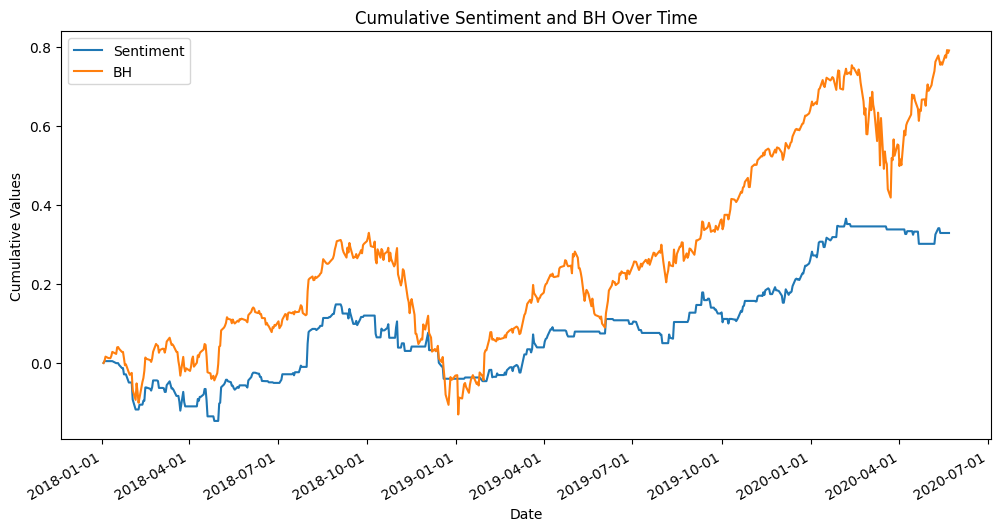

/var/folders/jp/ccdbvftd4pg2qt6s4b7bkv5m0000gn/T/ipykernel_11120/1773503202.py:6: RuntimeWarning: invalid value encountered in power
  annRetx = (np.power(cumRetx.iloc[-1] + 1, 252 / len(x)) - 1)


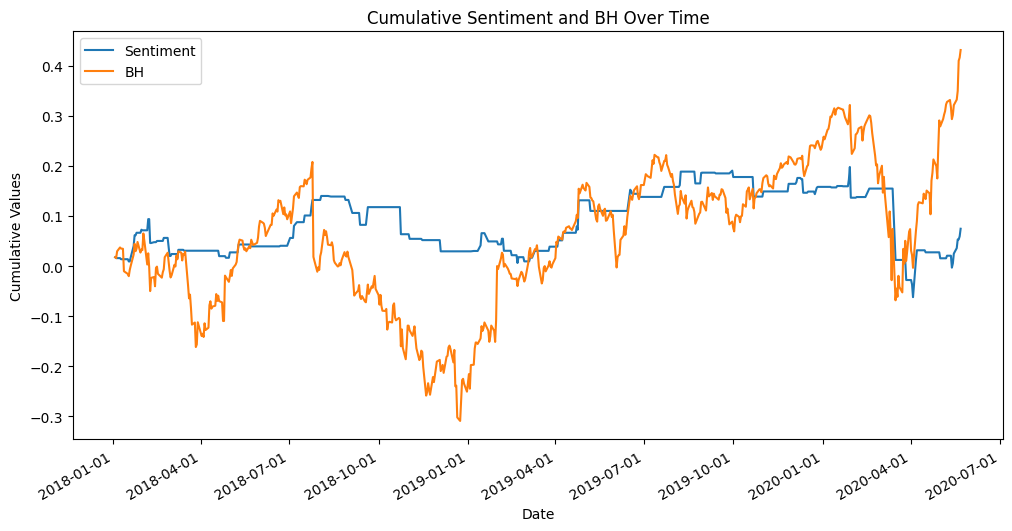

AAPL Results:
                           Sentiment          BH
Cumulative Return         -1.850792    0.771744
Annual Return                   NaN    0.271535
Annualized Sharpe Ratio         NaN  199.379302
Win %                      0.521739    0.541667
Annualized Volatility      0.165813    0.343199
Maximum Drawdown          -0.512420   -0.923330
Max Length Drawdown        0.000000    0.000000
n.trades                 218.000000    2.000000


FB Results:
                           Sentiment         BH
Cumulative Return         -1.573153   0.393796
Annual Return                   NaN   0.149645
Annualized Sharpe Ratio         NaN  99.713469
Win %                      0.557522   0.525084
Annualized Volatility      0.161414   0.378188
Maximum Drawdown          -0.191718  -0.740794
Max Length Drawdown        0.000000   0.000000
n.trades                 163.000000   2.000000


In [267]:
# Full period test
aapl_res = test_sentiment_strategy(aapl_target, aapl_ev, threshold=50, long_only=True, tcost=0.01)
fb_res = test_sentiment_strategy(fb_target, fb_ev, threshold=50, long_only=True, tcost=0.01)

print("AAPL Results:\n", aapl_res)
print('\n')
print("FB Results:\n", fb_res)

In [268]:
# Rolling window analysis
aapl_rolling_perf = rolling_test_sentiment_strategy(aapl_target, aapl_ev, threshold=50, long_only=True, w_size=127)
fb_rolling_perf = rolling_test_sentiment_strategy(fb_target, fb_ev, threshold=50, long_only=True, w_size=127)

print("AAPL Rolling Performance:\n", aapl_rolling_perf)
print('\n')
print("FB Rolling Performance:\n", fb_rolling_perf)

AAPL Rolling Performance:
 {'AvgPerf':      AvgPerf
BH  0.001268
Me  0.000763, 'NumWindows': 474}


FB Rolling Performance:
 {'AvgPerf':      AvgPerf
BH  0.000419
Me  0.000138, 'NumWindows': 474}


# FIRST TRY WITH LIMIT THRESHOLDS

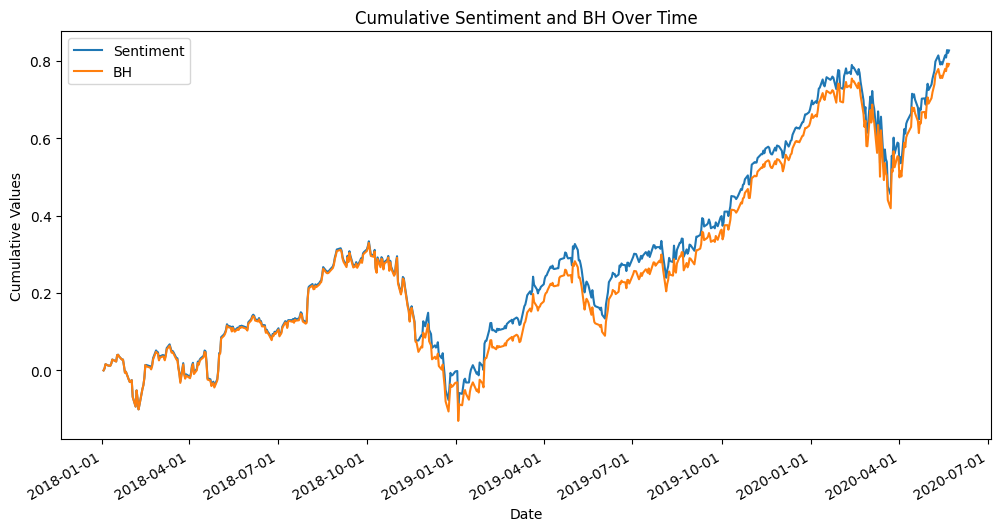

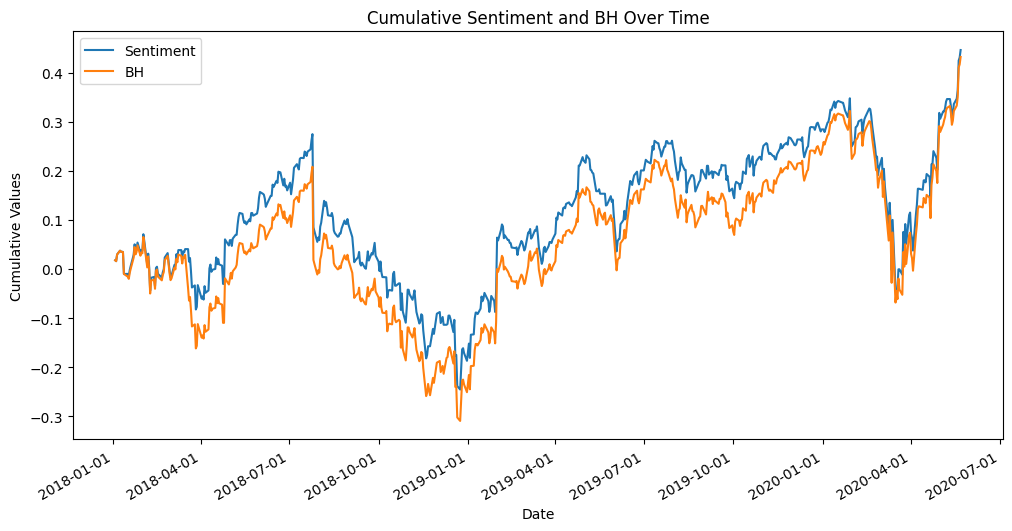

AAPL Results:
                           Sentiment          BH
Cumulative Return          0.676886    0.771744
Annual Return              0.242486    0.271535
Annualized Sharpe Ratio  178.390899  199.379302
Win %                      0.543919    0.541667
Annualized Volatility      0.342542    0.343199
Maximum Drawdown          -0.929029   -0.923330
Max Length Drawdown        0.000000    0.000000
n.trades                  15.000000    2.000000


FB Results:
                           Sentiment         BH
Cumulative Return         -0.362093   0.393796
Annual Return             -0.172062   0.149645
Annualized Sharpe Ratio -116.964062  99.713469
Win %                      0.531532   0.525084
Annualized Volatility      0.370708   0.378188
Maximum Drawdown          -0.691011  -0.740794
Max Length Drawdown        0.000000   0.000000
n.trades                  79.000000   2.000000


In [269]:
# Full period test
aapl_res = test_sentiment_strategy(aapl_target, aapl_ev, threshold=1, long_only=True, tcost=0.01)
fb_res = test_sentiment_strategy(fb_target, fb_ev, threshold=1, long_only=True, tcost=0.01)

print("AAPL Results:\n", aapl_res)
print('\n')
print("FB Results:\n", fb_res)

In [270]:
# Rolling window analysis
aapl_rolling_perf = rolling_test_sentiment_strategy(aapl_target, aapl_ev, threshold=1, long_only=True, w_size=254)
fb_rolling_perf = rolling_test_sentiment_strategy(fb_target, fb_ev, threshold=1, long_only=True, w_size=254)

print("AAPL Rolling Performance:\n", aapl_rolling_perf)
print('\n')
print("FB Rolling Performance:\n", fb_rolling_perf)

AAPL Rolling Performance:
 {'AvgPerf':      AvgPerf
BH  0.001050
Me  0.001138, 'NumWindows': 347}


FB Rolling Performance:
 {'AvgPerf':      AvgPerf
BH  0.000583
Me  0.000546, 'NumWindows': 347}


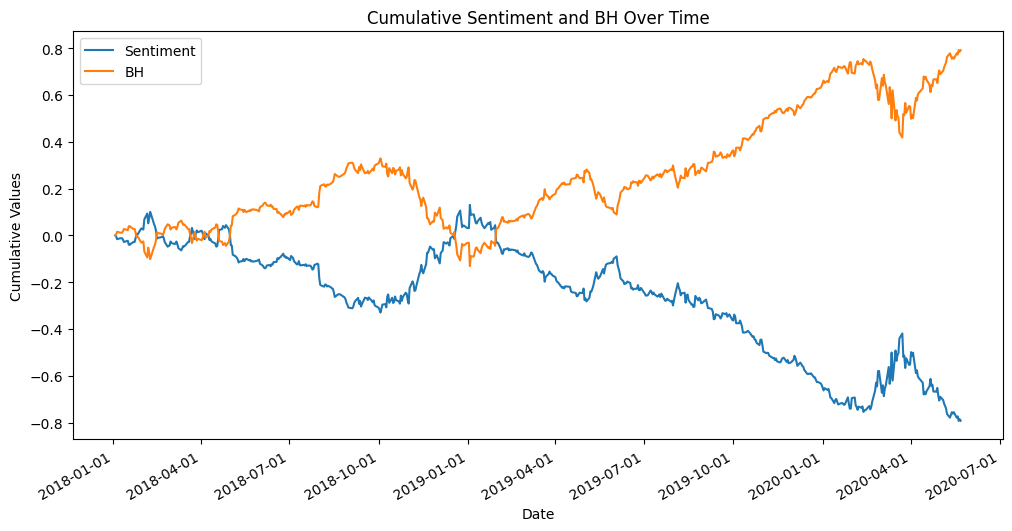

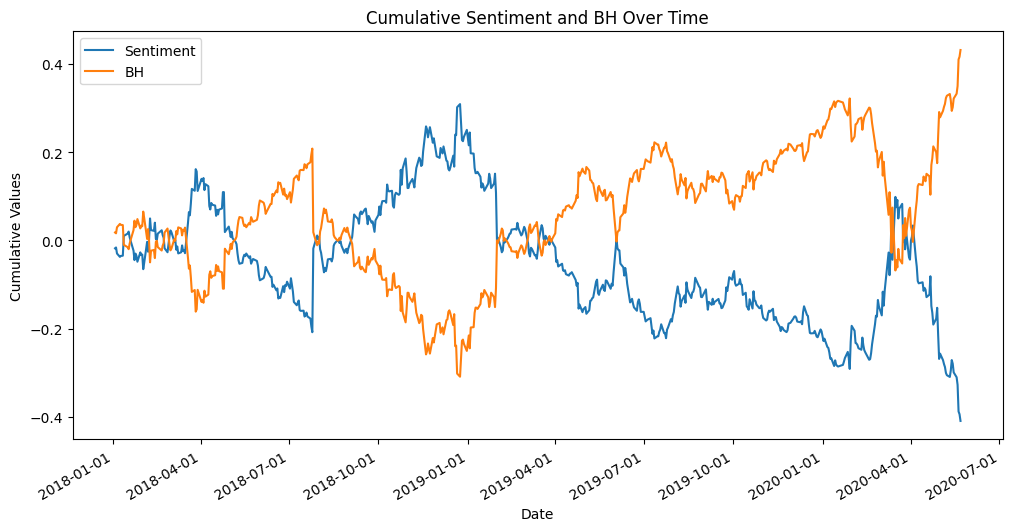

AAPL Results:
                           Sentiment          BH
Cumulative Return         -0.801744    0.771744
Annual Return             -0.493201    0.271535
Annualized Sharpe Ratio -362.141541  199.379302
Win %                      0.458333    0.541667
Annualized Volatility      0.343199    0.343199
Maximum Drawdown          -0.460220   -0.923330
Max Length Drawdown        0.000000    0.000000
n.trades                   1.000000    2.000000


FB Results:
                           Sentiment         BH
Cumulative Return         -0.441476   0.393796
Annual Return             -0.217008   0.149645
Annualized Sharpe Ratio -144.593293  99.713469
Win %                      0.474916   0.525084
Annualized Volatility      0.378205   0.378188
Maximum Drawdown          -0.517269  -0.740794
Max Length Drawdown        0.000000   0.000000
n.trades                   5.000000   2.000000


In [271]:
# Full period test
aapl_res = test_sentiment_strategy(aapl_target, aapl_ev, threshold=99, long_only=False, tcost=0.01)
fb_res = test_sentiment_strategy(fb_target, fb_ev, threshold=99, long_only=False, tcost=0.01)

print("AAPL Results:\n", aapl_res)
print('\n')
print("FB Results:\n", fb_res)

In [272]:
# Rolling window analysis
aapl_rolling_perf = rolling_test_sentiment_strategy(aapl_target, aapl_ev, threshold=99, long_only=False, w_size=254)
fb_rolling_perf = rolling_test_sentiment_strategy(fb_target, fb_ev, threshold=99, long_only=False, w_size=254)

print("AAPL Rolling Performance:\n", aapl_rolling_perf)
print('\n')
print("FB Rolling Performance:\n", fb_rolling_perf)

AAPL Rolling Performance:
 {'AvgPerf':     AvgPerf
BH  0.00105
Me -0.00105, 'NumWindows': 347}


FB Rolling Performance:
 {'AvgPerf':      AvgPerf
BH  0.000583
Me -0.000544, 'NumWindows': 347}


# nse

/var/folders/jp/ccdbvftd4pg2qt6s4b7bkv5m0000gn/T/ipykernel_11120/1773503202.py:6: RuntimeWarning: invalid value encountered in power
  annRetx = (np.power(cumRetx.iloc[-1] + 1, 252 / len(x)) - 1)


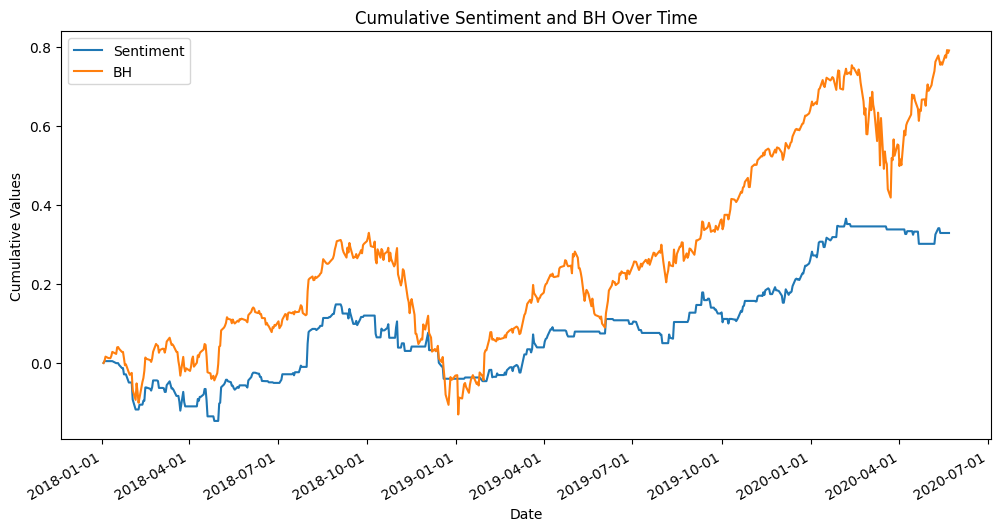

/var/folders/jp/ccdbvftd4pg2qt6s4b7bkv5m0000gn/T/ipykernel_11120/1773503202.py:6: RuntimeWarning: invalid value encountered in power
  annRetx = (np.power(cumRetx.iloc[-1] + 1, 252 / len(x)) - 1)


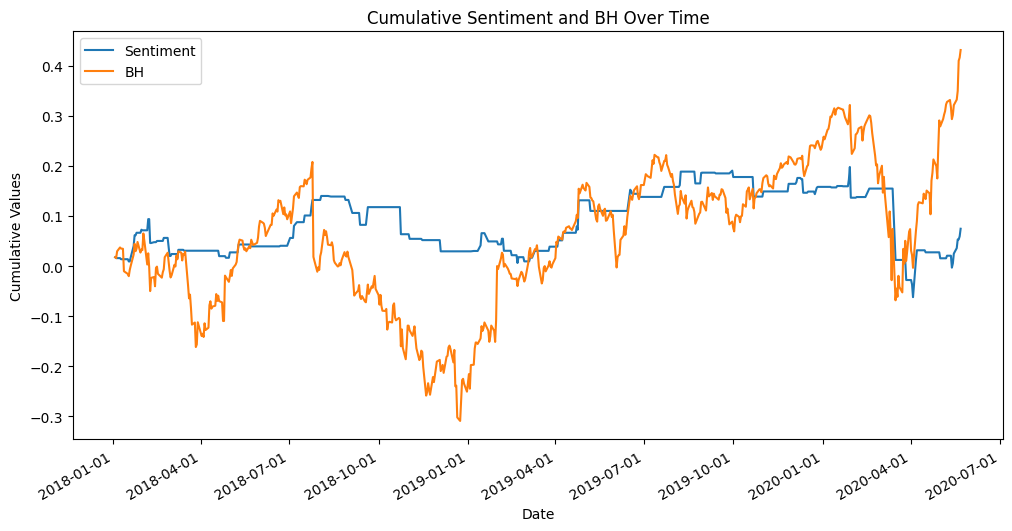

AAPL Results:
                           Sentiment          BH
Cumulative Return         -1.850792    0.771744
Annual Return                   NaN    0.271535
Annualized Sharpe Ratio         NaN  199.379302
Win %                      0.521739    0.541667
Annualized Volatility      0.165813    0.343199
Maximum Drawdown          -0.512420   -0.923330
Max Length Drawdown        0.000000    0.000000
n.trades                 218.000000    2.000000


FB Results:
                           Sentiment         BH
Cumulative Return         -1.573153   0.393796
Annual Return                   NaN   0.149645
Annualized Sharpe Ratio         NaN  99.713469
Win %                      0.557522   0.525084
Annualized Volatility      0.161414   0.378188
Maximum Drawdown          -0.191718  -0.740794
Max Length Drawdown        0.000000   0.000000
n.trades                 163.000000   2.000000


In [273]:
# Full period test
aapl_res = test_sentiment_strategy(aapl_target, aapl_ev, threshold=50, long_only=True, tcost=0.01)
fb_res = test_sentiment_strategy(fb_target, fb_ev, threshold=50, long_only=True, tcost=0.01)

print("AAPL Results:\n", aapl_res)
print('\n')
print("FB Results:\n", fb_res)

In [274]:
# Rolling window analysis
aapl_rolling_perf = rolling_test_sentiment_strategy(aapl_target, aapl_ev, threshold=50, long_only=True, w_size=127)
fb_rolling_perf = rolling_test_sentiment_strategy(fb_target, fb_ev, threshold=50, long_only=True, w_size=127)

print("AAPL Rolling Performance:\n", aapl_rolling_perf)
print('\n')
print("FB Rolling Performance:\n", fb_rolling_perf)

AAPL Rolling Performance:
 {'AvgPerf':      AvgPerf
BH  0.001268
Me  0.000763, 'NumWindows': 474}


FB Rolling Performance:
 {'AvgPerf':      AvgPerf
BH  0.000419
Me  0.000138, 'NumWindows': 474}
